## Group 7 NLP

In [ ]:
#!pip install spacy
#!pip install plotly
#!pip install nltk
#!pip install datasets
#!pip install setfit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We import the libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,  roc_curve, auc
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import log_loss


from tqdm import tqdm # duration counter
import nltk # nlp tools with nltk
from nltk.corpus import stopwords # corpus' stopwords

import string # for alphabet letters, punctuations and unicode characters
from math import log2 # to apply logarithm scale

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import spacy
import re

In [ ]:
# download stopwords for later usage
nltk.download('stopwords')

# download tagger for pos tags
nltk.download('averaged_perceptron_tagger')

# download wordnet
nltk.download('wordnet')

# installing the medium english model of spacy
!python3 -m spacy download en_core_web_md -q
!pip install pyspellchecker -q

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 25.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 131.6 MB/s eta 0:00:00


In [ ]:
# load the spacy model
nlp = spacy.load('en_core_web_md')
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text) #remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text


## Preprocessing

In [ ]:
# We load our dataset
# online banking queries annotated with their corresponding intents.
train = pd.read_csv('/content/drive/MyDrive/NLP/Group7_NLP/train.csv')
test = pd.read_csv('/content/drive/MyDrive/NLP/Group7_NLP/test.csv')

In [ ]:
print("test data shape",test.shape)
test.sample(5)

test data shape (3080, 2)


,text,category
2276,Is my salary eligible for this?,receiving_money
1689,I wasn't charged the correct amount for an ite...,request_refund
975,Does this card work everywhere?,card_acceptance
2191,"My beneficiary is not allowed, please may I ha...",beneficiary_not_allowed
1394,What can I use a virtual disposable card for?,disposable_card_limits


In [ ]:
print("train data shape",train.shape)
train.sample(5)


train data shape (10003, 2)


,text,category
7983,Can cash be used in physical locations to top up?,top_up_by_cash_or_cheque
3395,"I had a cheque deposited, but I don't see my m...",balance_not_updated_after_cheque_or_cash_deposit
8832,My card shows a cash withdrawal I don't recogn...,cash_withdrawal_not_recognised
8587,What was the issue with my topping up?,top_up_failed
3634,I need help with some transactions in my accou...,card_payment_not_recognised


So we have 10003 observations in the training set and 3080 in the test set, 2 variables (text and category).

In [ ]:
# Check the NaN values
train.isnull().sum()

,0
text,0
category,0


In [ ]:
test.isnull().sum()

,0
text,0
category,0


In [ ]:
#Check the types of the variables
print(train.columns)
train.info()

Index(['text', 'category'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [ ]:
print(test.columns)
test.info()

Index(['text', 'category'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3080 non-null   object
 1   category  3080 non-null   object
dtypes: object(2)
memory usage: 48.3+ KB


In [ ]:
# Check for duplicated rows
len(train.loc[train.duplicated()])

0

In [ ]:
len(test.loc[test.duplicated()])

0

We don't have duplicated rows.

In [ ]:
print("The number of categories in our dataset:",train['category'].nunique())

The number of categories in our dataset: 77


In [ ]:
category_counts = train['category'].value_counts().reset_index()
category_counts.columns = ['category','count']

fig = px.bar(
    category_counts.sort_values('count',ascending=False),
    x = 'count',
    y = 'category',
    orientation = 'h',
    title = 'Repartition of the 77 categories in the training dataset'
)

fig.update_layout(height=800, width=800)
fig.show()

We can see that out train dataset is not balanced, some categories are more represented than the other ones.

In [ ]:
# Apply the cleaning
train['text_clean'] = train['text'].apply(clean_text)
test['text_clean'] = test['text'].apply(clean_text)

In [ ]:
#Vectorization with TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train = vectorizer.fit_transform(train['text_clean'])
X_test = vectorizer.transform(test['text_clean'])

y_train = train['category']
y_test = test['category']

In [ ]:
# Model training (LogisticRegression)
model = LogisticRegression(max_iter=1000, class_weight='balanced') #balanced to adjust the weight and resolve the problem of unbalanced data.
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report1 = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.82      0.90      0.86        40
                                activate_my_card       1.00      0.93      0.96        40
                                       age_limit       0.97      0.97      0.97        40
                         apple_pay_or_google_pay       0.93      0.97      0.95        40
                                     atm_support       0.88      0.88      0.88        40
                                automatic_top_up       1.00      0.90      0.95        40
         balance_not_updated_after_bank_transfer       0.65      0.78      0.70        40
balance_not_updated_after_cheque_or_cash_deposit       0.86      0.93      0.89        40
                         beneficiary_not_allowed       0.97      0.78      0.86        40
                                 cancel_transfer       0.88      0.95      0.92        40
         

In [ ]:
def predict_category(text):
    text_cleaned = clean_text(text)
    text_v = vectorizer.transform([text_cleaned])
    prediction = model.predict(text_v)
    return prediction[0]

In [ ]:
sentence = "I am seeing a payment that I don't recognize."
predicted_category = predict_category(sentence)

print("Predicted category: ",predicted_category)

Predicted category:  card_payment_not_recognised


In [ ]:
sent2 = "I lost my card PIN, I want to change it."
predicted_category = predict_category(sent2)

print("Predicted category: ",predicted_category)

Predicted category:  change_pin


In [ ]:
sent3 = "I want to pay an item in my mobile video game, which app can I use? (Google)"
predicted_category = predict_category(sent3)

print("Predicted category: ",predicted_category)

Predicted category:  apple_pay_or_google_pay


In [ ]:
sent4 = "I didn't find my phone since 2 weeks, is my bank account safe?"
predicted_category = predict_category(sent4)

print("Predicted category: ",predicted_category)

Predicted category:  lost_or_stolen_phone


In [ ]:
sent5 = "How can I do payments on Google Play store with Google Pay?"
predicted_s5 = predict_category(sent4)

print("Predicted category: ",predicted_s5)

Predicted category:  lost_or_stolen_phone


In [ ]:
#!pip install gensim

### Using Embedding

In [ ]:

!pip install transformers -q

In [ ]:
from sentence_transformers import SentenceTransformer
#from transformers import DistilBertTokenizer, DistilBertModel
import torch

In [ ]:
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
#embedder = SentenceTransformer('all-MiniLM-L6-V2')

In [ ]:
#Using MPNet-v2
embedder = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

X_train_e = embedder.encode(train['text_clean'].tolist(), convert_to_numpy=True)
X_test_e = embedder.encode(test['text_clean'].tolist(), convert_to_numpy=True)

y_train_e = train['category']
y_test_e = test['category']


In [ ]:
model_e = LogisticRegression(max_iter=1000, class_weight='balanced')
model_e.fit(X_train_e, y_train_e)
y_pred_e = model_e.predict(X_test_e)

report2 = classification_report(y_test_e, y_pred_e, output_dict=True)
print(classification_report(y_test_e, y_pred_e))


                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.93      0.95      0.94        40
                                activate_my_card       0.97      0.90      0.94        40
                                       age_limit       0.93      0.97      0.95        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       0.90      0.90      0.90        40
                                automatic_top_up       0.97      0.90      0.94        40
         balance_not_updated_after_bank_transfer       0.83      0.72      0.77        40
balance_not_updated_after_cheque_or_cash_deposit       0.93      0.97      0.95        40
                         beneficiary_not_allowed       0.88      0.75      0.81        40
                                 cancel_transfer       0.90      0.95      0.93        40
         

In [ ]:
def predict_category_e(text): #With embeddings
    text_cleaned = clean_text(text)
    embedding = embedder.encode([text_cleaned], convert_to_numpy=True)
    prediction = model_e.predict(embedding)
    return prediction[0]


In [ ]:
sentence = "I am seeing a payment that I don't recognize."
predicted_s1 = predict_category_e(sentence)

print("Predicted category: ",predicted_s1)

Predicted category:  card_payment_not_recognised


In [ ]:
sent2 = "I lost my pin code, I want to change it."
predicted_s2 = predict_category_e(sent2)

print("Predicted category: ",predicted_s2)

Predicted category:  change_pin


In [ ]:
sent3 = "I want to pay an item in my mobile video game, which app can I use?"
predicted_s3 = predict_category_e(sent3)

print("Predicted category: ",predicted_s3)

Predicted category:  card_payment_not_recognised


In [ ]:
sent4 = "I didn't find my phone since 2 weeks, is my bank account safe?"
predicted_s4 = predict_category_e(sent4)

print("Predicted category: ",predicted_s4)

Predicted category:  lost_or_stolen_phone


In [ ]:
sent5 = "How can I do payments on Google Play store with Google Pay?"
predicted_s5 = predict_category_e(sent4)

print("Predicted category: ",predicted_s5)

Predicted category:  lost_or_stolen_phone


### Let's compare the results of these 2 classifications (The one using TF-IDF and the one using Embeddings)

In [ ]:
metrics = ['precision','recall','f1-score']

comparison = pd.DataFrame({
    'Metrics': metrics,
    'Report1_macro' : [report1['macro avg'][m] for m in metrics],
    'Report2_macro' : [report2['macro avg'][m] for m in metrics],
    'Report1_weighted' : [report1['weighted avg'][m] for m in metrics],
    'Report2_weighted' : [report2['weighted avg'][m] for m in metrics],
})
print("Report1(vectorization with TF-IDF), Report2(vectorization with Embeddings)")
comparison

### Using MLPClassifier


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_e)
y_test_encoded = le.transform(y_test_e)

In [ ]:
model2 = MLPClassifier(hidden_layer_sizes=(256,), max_iter=300, random_state=42, early_stopping=True)
model2.fit(X_train_e, y_train_encoded)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(256,), max_iter=300,
              random_state=42)

In [ ]:
#Predict and evaluate
y_pred_encoded = model2.predict(X_test_e)

y_pred_e_2 = le.inverse_transform(y_pred_encoded)

report3 = classification_report(y_test_e, y_pred_e_2, output_dict=True)
print(classification_report(y_test_e, y_pred_e_2))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.97      0.88      0.92        40
                                activate_my_card       0.95      0.97      0.96        40
                                       age_limit       0.97      0.97      0.97        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       0.97      0.93      0.95        40
                                automatic_top_up       0.95      0.93      0.94        40
         balance_not_updated_after_bank_transfer       0.66      0.72      0.69        40
balance_not_updated_after_cheque_or_cash_deposit       0.97      0.93      0.95        40
                         beneficiary_not_allowed       0.90      0.90      0.90        40
                                 cancel_transfer       0.93      0.97      0.95        40
         

In [ ]:
def predict_category_2(text): #With embeddings
    text_cleaned = clean_text(text)
    embedding = embedder.encode([text_cleaned], convert_to_numpy=True)
    prediction = model2.predict(embedding)
    return prediction[0]


In [ ]:
sentence = "I am seeing a payment that I don't recognize."
predicted_s1 = predict_category_2(sentence)

print("Predicted category: ",predicted_s1)

Predicted category:  17


which corresponds "card_payment_not_recognised"

In [ ]:
sent2 = "I lost my pin code, I want to change it."
predicted_s2 = predict_category_2(sent2)

print("Predicted category: ",predicted_s2)

Predicted category:  22


which corresponds "change_pin"

In [ ]:
sent3 = "I want to pay an item in my mobile video game, which app can I use?"
predicted_s3 = predict_category_2(sent3)

print("Predicted category: ",predicted_s3)


Predicted category:  17


which corresponds "card_payment_not_recognised"

In [ ]:
sent4 = "I didn't find my phone since 2 weeks, is my bank account safe?"
predicted_s4 = predict_category_2(sent4)

print("Predicted category: ",predicted_s4)

Predicted category:  43


"lost_or_stolen_phone"

In [ ]:
sent5 = "How can I do payments on Google Play store with Google Pay?"
predicted_s5 = predict_category_2(sent4)

print("Predicted category: ",predicted_s5)

Predicted category:  43


"lost_or_stolen_phone"

In [ ]:
metrics = ['precision','recall','f1-score']

comparison = pd.DataFrame({
    'Metrics': metrics,
    'Report1_macro' : [report1['macro avg'][m] for m in metrics],
    'Report2_macro' : [report2['macro avg'][m] for m in metrics],
    'Report3_macro' : [report3['macro avg'][m] for m in metrics],
    'Report1_weighted' : [report1['weighted avg'][m] for m in metrics],
    'Report2_weighted' : [report2['weighted avg'][m] for m in metrics],
    'Report3_weighted' : [report3['weighted avg'][m] for m in metrics],
})
print("Report1(vectorization with TF-IDF), Report2(vectorization with Embeddings), Report3(Embeddings of MPNet and MLP)")
comparison

Report1(vectorization with TF-IDF), Report2(vectorization with Embeddings), Report3(Embeddings of MPNet and MLP)


,Metrics,Report1_macro,Report2_macro,Report3_macro,Report1_weighted,Report2_weighted,Report3_weighted
0,precision,0.861727,0.880192,0.898342,0.861727,0.880192,0.898342
1,recall,0.853896,0.875000,0.894481,0.853896,0.875000,0.894481
2,f1-score,0.854376,0.874744,0.894763,0.854376,0.874744,0.894763


Casanueva et al. [5] discovered class overlaps in creating Banking77. 14% of the dataset queries are misclassified so the called an expert to correct these error in a sample of this dataset.

## Using Neural Network on the cured banking77 dataset


In [ ]:
embedder = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Group7_NLP/best3_train.csv')
df.head()

,text,label_name,label
0,"My new card is here, what's the process for ac...",activate_my_card,0
1,"I am unable to activate my card, it won't let me.",activate_my_card,0
2,Can you help me activate my card,activate_my_card,0
3,What is the youngest age for an account?,age_limit,1
4,What is the appropriate age for my child to be...,age_limit,1


In [ ]:
df.shape

(231, 3)

In [ ]:
texts = df['text'].tolist()
labels = df['label_name'].tolist()


In [ ]:
le = LabelEncoder()
y = le.fit_transform(labels)
n_classes = len(le.classes_)

X = embedder.encode(texts, convert_to_numpy=True)

In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=1/3,
    random_state = 42,
    stratify=df['label']
)
print(train_df.shape)
print(test_df.shape)

(154, 3)
(77, 3)


In [ ]:
train_df.head()

,text,label_name,label
48,There were a couple of payments that I have no...,card_payment_not_recognised,16
154,Where is my recent refund in the my statement?,Refund_not_showing_up,51
30,What businesses accept this card?,card_acceptance,10
73,I just moved to the US how do I get a card?,country_support,24
151,How to receive transfers from my employer when...,receiving_money,50


In [ ]:

X_train_2 = embedder.encode(train_df['text'].tolist(), convert_to_numpy=True)
X_test_2 = embedder.encode(test_df['text'].tolist(), convert_to_numpy=True)

y_train_2 = train_df['label']
y_test_2 = test_df['label']


In [ ]:
class IntentDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_ds = IntentDataset(X_train_2, y_train_2.values)
test_ds = IntentDataset(X_test_2, y_test_2.values)

#data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=16)

In [ ]:
# NN model
class IntentClassifier(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(in_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim, out_dim)
    )
  def forward(self, x):
    return self.fc(x)

model2 = IntentClassifier(in_dim=X.shape[1], hidden_dim=256, out_dim=n_classes)

In [ ]:
# some hyperparameters
criterion = nn.CrossEntropyLoss()
lr = 1e-3
n_epochs = 80
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

IntentClassifier(
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=77, bias=True)
  )
)

In [ ]:
#Training
losses =[]
for epoch in range(n_epochs):
  model2.train()
  total_loss = 0
  for x_batch, y_batch in train_dl:
    print(type(x_batch), x_batch.shape)
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    y_pred = model2(x_batch)
    loss = criterion(y_pred, y_batch)
    loss.backward()#backpropag
    optimizer.step()#update params
    total_loss += loss.item()
  losses.append(total_loss)
  #print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([10, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([10, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'torch.Tensor'> torch.Size([16, 768])
<class 'to

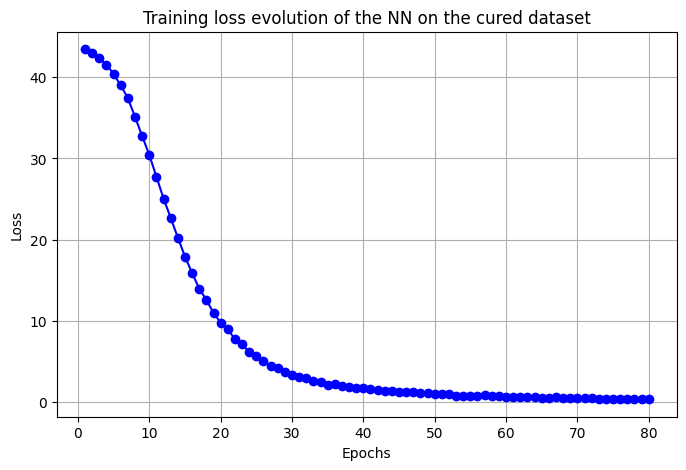

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1,n_epochs+1), losses, marker='o', color='blue')
plt.title("Training loss evolution of the NN on the cured dataset")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# evaluation
model2.eval()
y_true, y_pred = [], []

with torch.no_grad():
  for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    logits = model2(x_batch)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    y_pred.extend(preds)
    y_true.extend(y_batch.numpy())

print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.50      1.00      0.67         1
                                activate_my_card       1.00      1.00      1.00         1
                                       age_limit       1.00      1.00      1.00         1
                         apple_pay_or_google_pay       0.00      0.00      0.00         1
                                     atm_support       0.00      0.00      0.00         1
                                automatic_top_up       1.00      1.00      1.00         1
         balance_not_updated_after_bank_transfer       1.00      1.00      1.00         1
balance_not_updated_after_cheque_or_cash_deposit       0.00      0.00      0.00         1
                         beneficiary_not_allowed       1.00      1.00      1.00         1
                                 cancel_transfer       1.00      1.00      1.00         1
         

##SetFit (Sentence Transformer Fine-tuning)

It is an efficient and prompt-free frame-
work for few-shot fine-tuning of Sentence
Transformers (ST). SETFIT works by first fine-
tuning a pretrained ST on a small number of
text pairs, in a contrastive Siamese manner.
The resulting model is then used to generate
rich text embeddings, which are used to train a
classification head. This simple framework re-
quires no prompts or verbalizers, and achieves
high accuracy with orders of magnitude less
parameters than existing techniques.

source : Efficient Few-Shot Learning Without Prompts
Authors:
Lewis Tunstall , Nils Reimers , Unso Eun Seo Jo , Luke Bates ,
Daniel Korat , Moshe Wasserblat , Oren Pereg


In [ ]:
from IPython.display import HTML
HTML('<span style="color:red"><b>Warning</b>: The SetFit model is huge (105M of parameters) and the execution time is long (5 hours for us).</span>')

In [ ]:
!pip install datasets
!pip install setfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
from setfit import SetFitModel, SetFitTrainer
from datasets import load_dataset,Dataset
import os
os.environ["WANDB_DISABLED"] = "true"


df2 = load_dataset('banking77')

train_df = df2['train'].to_pandas()

#We select 20 examples per class (20-shot)
shot_per_class = 20
fewshot_samples = train_df.groupby('label').apply(lambda x: x.sample(shot_per_class)).reset_index(drop=True)

fewshot_dataset = Dataset.from_pandas(fewshot_samples)

#Using MPNet-v2
model4 = SetFitModel.from_pretrained('sentence-transformers/all-mpnet-base-v2',num_labels=77)


<ipython-input-39-6df30945fbb4>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fewshot_samples = train_df.groupby('label').apply(lambda x: x.sample(shot_per_class)).reset_index(drop=True)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Group7_NLP/best3_train.csv')
df.head()

,text,label_name,label
0,"My new card is here, what's the process for ac...",activate_my_card,0
1,"I am unable to activate my card, it won't let me.",activate_my_card,0
2,Can you help me activate my card,activate_my_card,0
3,What is the youngest age for an account?,age_limit,1
4,What is the appropriate age for my child to be...,age_limit,1


In [ ]:
label_map_df = df[['label', 'label_name']].drop_duplicates()
label_map_df

,label,label_name
0,0,activate_my_card
3,1,age_limit
6,2,apple_pay_or_google_pay
9,3,atm_support
12,4,automatic_top_up
...,...,...
216,72,virtual_card_not_working
219,73,visa_or_mastercard
222,74,why_verify_identity
225,75,wrong_amount_of_cash_received


In [ ]:
column_mapping={"text":"text", "label":"label"}

In [ ]:
trainer = SetFitTrainer(
    model = model4,
    train_dataset = fewshot_dataset,
    eval_dataset=df2['test'],
    metric="accuracy",
    column_mapping= column_mapping,
    num_iterations = 5,
    num_epochs = 1,
    batch_size=32
)

In [ ]:
trainer.train()

In [ ]:
trainer.model.save_pretrained('/content/drive/MyDrive/NLP/Group7_NLP/setfit_banking77_model')

In [ ]:
trainer.model.save_pretrained("/content/test_model")
!ls /content/test_model


In [ ]:
test_df = df2['test']
texts = test_df['text']
true_labels = test_df['label']
pred_labels = trainer.model.predict(texts)

In [ ]:
metrics = trainer.evaluate()
print("20-shot performance", metrics)

***** Running evaluation *****


20-shot performance {'accuracy': 0.8577922077922078}


In [ ]:
import json


label_map = label_map_df.set_index('label')['label_name'].to_dict()

with open("/content/drive/MyDrive/NLP/Group7_NLP/setfit_banking77_model/label_map.json", "w") as f:
    json.dump(label_map, f, indent=2)

target_names = [label_map[i] for i in sorted(set(true_labels))]

print(classification_report(true_labels, pred_labels, target_names=target_names))


                                                  precision    recall  f1-score   support

                                activate_my_card       0.95      0.93      0.94        40
                                       age_limit       0.89      1.00      0.94        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       1.00      0.97      0.99        40
                                automatic_top_up       0.97      0.85      0.91        40
         balance_not_updated_after_bank_transfer       0.72      0.70      0.71        40
balance_not_updated_after_cheque_or_cash_deposit       0.93      0.93      0.93        40
                         beneficiary_not_allowed       0.82      0.68      0.74        40
                                 cancel_transfer       0.93      0.97      0.95        40
                            card_about_to_expire       0.95      1.00      0.98        40
         

In [ ]:
#Prediction on a new sentence
pred = trainer.model.predict(['I want to block my card'])
pred_label = pred[0].item() if hasattr(pred[0], 'item') else pred[0]
print("Predicted label ID:", pred_label)
print("Predicted intent:", label_map[pred_label])

Predicted label ID: 49
Predicted intent: pin_blocked


In [ ]:
sent5 = "How can I do payments on Google Play store?"
pred = trainer.model.predict([sent5])
pred_label = pred[0].item() if hasattr(pred[0], 'item') else pred[0]
print("Predicted label ID:", pred_label)
print("Predicted intent:", label_map[pred_label])

Predicted label ID: 2
Predicted intent: apple_pay_or_google_pay


In [ ]:
sent3 = "I want to pay an item in my mobile video game, which app can I use?"
pred = trainer.model.predict([sent3])
pred_label = pred[0].item() if hasattr(pred[0], 'item') else pred[0]
print("Predicted label ID:", pred_label)
print("Predicted intent:", label_map[pred_label])

Predicted label ID: 2
Predicted intent: apple_pay_or_google_pay


In [ ]:
sent4 = "I didn't find my phone since 2 weeks, is my bank account safe?"
pred = trainer.model.predict([sent4])
pred_label = pred[0].item() if hasattr(pred[0], 'item') else pred[0]
print("Predicted label ID:", pred_label)
print("Predicted intent:", label_map[pred_label])

Predicted label ID: 42
Predicted intent: lost_or_stolen_phone


We can see that all the queries that were not well classified by the previous models are now in their right classes. Now let's test SetFit on 3-shot for the cured banking77 dataset.

## SetFit on the cured dataset

In [ ]:
from setfit import SetFitModel, SetFitTrainer
from datasets import load_dataset,Dataset
from sklearn.preprocessing import LabelEncoder
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Group7_NLP/best3_train.csv')
df.head()

,text,label_name,label
0,"My new card is here, what's the process for ac...",activate_my_card,0
1,"I am unable to activate my card, it won't let me.",activate_my_card,0
2,Can you help me activate my card,activate_my_card,0
3,What is the youngest age for an account?,age_limit,1
4,What is the appropriate age for my child to be...,age_limit,1


In [ ]:
model_c = SetFitModel.from_pretrained('sentence-transformers/all-mpnet-base-v2',num_labels=77)
column_mapping={"text":"text", "label":"label"}

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
texts = df['text'].tolist()
labels = df['label_name'].tolist()

le = LabelEncoder()
y = le.fit_transform(labels)
n_classes = len(le.classes_)


train_df, test_df = train_test_split(
    df,
    test_size=1/3,
    random_state = 42,
    stratify=df['label']
)
print(train_df.shape)
print(test_df.shape)
train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

(154, 3)
(77, 3)


In [ ]:
trainer = SetFitTrainer(
    model = model_c,
    train_dataset= train_df,
    eval_dataset= test_df,
    #metric= 'accuracy',
    column_mapping= column_mapping,
    num_iterations = 5,
    num_epochs = 5,
    batch_size=32
)

<ipython-input-31-61729c5c08f3>:1: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/154 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

***** Running training *****
  Num unique pairs = 1540
  Batch size = 32
  Num epochs = 5


Step,Training Loss
1,0.075200
50,0.051700
100,0.023000
150,0.013500
200,0.009500


In [ ]:
from evaluate import load

metrics = ['accuracy', 'f1', 'precision', 'recall']
trainer.metric = 'accuracy'

results = trainer.evaluate()
print("Evaluation: ", results)

***** Running evaluation *****


Evaluation:  {'accuracy': 0.6883116883116883}


In [ ]:
label_map = label_map_df.set_index('label')['label_name'].to_dict()
texts = test_df['text']
true_labels = test_df['label']
pred_labels = trainer.model.predict(texts)

target_names = [label_map[i] for i in sorted(set(true_labels))]

print(classification_report(true_labels, pred_labels, target_names=target_names))


                                                  precision    recall  f1-score   support

                                activate_my_card       1.00      1.00      1.00         1
                                       age_limit       0.33      1.00      0.50         1
                         apple_pay_or_google_pay       1.00      1.00      1.00         1
                                     atm_support       0.50      1.00      0.67         1
                                automatic_top_up       0.00      0.00      0.00         1
         balance_not_updated_after_bank_transfer       1.00      1.00      1.00         1
balance_not_updated_after_cheque_or_cash_deposit       1.00      1.00      1.00         1
                         beneficiary_not_allowed       0.00      0.00      0.00         1
                                 cancel_transfer       1.00      1.00      1.00         1
                            card_about_to_expire       1.00      1.00      1.00         1
         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics = ['accuracy','recall','f1-score']

comparison = pd.DataFrame({
    'Metrics': metrics,
    'Report1_macro' : [report1['macro avg'][m] for m in metrics],
    'Report2_macro' : [report2['macro avg'][m] for m in metrics],
    'Report3_macro' : [report3['macro avg'][m] for m in metrics],
    'Report4_macro' : [0.57,0.68,0.61],
    'Report5_macro' : [0.86,0.86,0.86],
    'Report6_macro' : [0.61,0.69,0.63]
})
print("Report1(TF-IDF + Logistic Reg), Report2(Embeddings + Logistic Reg), Report3(Embeddings of MPNet and MLP), Report4(Neural Network with PyTorch), Report5(SetFit on banking77), Report6(SetFit on the cured dataset)")
comparison

Report1(TF-IDF + Logistic Reg), Report2(Embeddings + Logistic Reg), Report3(Embeddings of MPNet and MLP), Report4(Neural Network with PyTorch), Report5(SetFit on banking77), Report6(SetFit on the cured dataset)


,Metrics,Report1_macro,Report2_macro,Report3_macro,Report4_macro,Report5_macro,Report6_macro
0,precision,0.861727,0.880192,0.898342,0.57,0.86,0.61
1,recall,0.853896,0.875000,0.894481,0.68,0.86,0.69
2,f1-score,0.854376,0.874744,0.894763,0.61,0.86,0.63


# Interpretation

We notice that the MLPClassifier has the highest macro scores (precision, recall, f1-score) on the test set, but SetFit performed better on unseen user queries. This is due to a distribution mismatch: the test data closely resembles the training set and this helps the direct vector-to-class mapping of MLP. However, MLP lacks semantic flexibility and struggles with sentence variations but SetFit's contrastive fine-tuning enables it to recognize intent across diverse formulations making it more robust for real-world prediction.

# Now we can add a LLM model to answer to the user queries in function of the intents detected with our model and some default answers.

In [ ]:
from setfit import SetFitModel, SetFitTrainer
import json

# We load the SetFitModel that we trained previously
model = SetFitModel.from_pretrained("/content/drive/MyDrive/NLP/Group7_NLP/setfit_banking77_model")

# Charger le label_map
with open("/content/drive/MyDrive/NLP/Group7_NLP/setfit_banking77_model/label_map.json", "r") as f:
    label_map = json.load(f)


label_map = {int(k): v for k, v in label_map.items()}

# predict function
def tester_phrases(text):
  pred = model.predict([text])
  label_id = pred[0]
  label_name = label_map[label_id.item()]
  return label_name

In [ ]:
# Required imports
import json
from datetime import datetime
import torch
from transformers import pipeline

# Load resources (the default intent responses)
with open("/content/drive/MyDrive/NLP/Group7_NLP/intent_responses.json") as f:
    intent_responses = json.load(f)

# Preload response generator (DistilGPT2)
response_generator = pipeline("text-generation",
                            model="distilgpt2",
                            device=0 if torch.cuda.is_available() else -1)

# Configuration
conversation_history = []
urgent_intents = {"compromised_card", "lost_or_stolen_card", "card_swallowed", "fraudulent_transactions"}

# Core functions
def verify_intent(intent, user_input):
    """Intent-specific verification questions"""
    verification_questions = {
        "activate_my_card": f"Do you want to activate your card as mentioned in: '{user_input}'?",
        "card_block": f"Do you want to block your card because of: '{user_input}'?",
        "account_blocked": f"Is your account blocked as stated in: '{user_input}'?",
        "balance_inquiry": f"Do you want to check your current balance? (Your request: '{user_input}')",
        "card_not_working": f"Is your card not working as described in: '{user_input}'?",
        "lost_or_stolen_card": f"Have you lost your card or was it stolen? (Your request: '{user_input}')",
        "default": f"Please confirm your request is about: {intent.replace('_', ' ')}?"
    }
    return verification_questions.get(intent, verification_questions["default"])

def generate_response(intent, user_input):
    """Generates appropriate response for confirmed intent"""
    if intent in urgent_intents:
        return f"[URGENT] {intent_responses.get(intent, '')}\nI'm transferring you to an agent immediately."

    if intent not in intent_responses:
        return "Let me transfer you to a specialized agent who can better assist you."

    # Use predefined response if available
    predefined_response = intent_responses.get(intent, "")
    if predefined_response:
        return predefined_response

    # Generate contextual response
    prompt = (
        f"As a banking assistant, provide a professional and concise response to this request:\n"
        f"Customer request: '{user_input}'\n"
        f"Issue type: {intent.replace('_', ' ')}\n"
        f"Response:"
    )

    response = response_generator(
        prompt,
        max_length=150,
        temperature=0.5,
        do_sample=True,
        top_k=30
    )[0]['generated_text']

    return response.split("Response:")[-1].strip()

# Main interaction interface
def handle_interaction():
    print("Banking Assistant: Hello! How can I help you today? (type 'quit' to exit)")

    while True:
        try:
            #  We get user input
            user_input = input("You: ").strip()
            if user_input.lower() in {'quit', 'exit'}:
                print("Assistant: Thank you for your visit. Goodbye!")
                return 0

            conversation_history.append(f"Customer: {user_input}")

            # We call our prediction function (which use our SetFit model)
            predicted_intent=tester_phrases(user_input.lower() )


            # We ask to the user to verify the model answer
            verification_q = verify_intent(predicted_intent, user_input)
            print(f"\nAssistant: {verification_q} (reply 'yes' or 'no')")

            # Handle user response
            user_feedback = input("You: ").lower().strip()

            if user_feedback.startswith(('yes', 'y')):
                # We provide response
                final_response = generate_response(predicted_intent, user_input)
                print(f"\nAssistant: {final_response}\n")
            elif user_feedback.startswith(('no', 'n')):
                # Request clarification
                print("\nAssistant: Could you please clarify your request?")
                new_details = input("You (details): ").strip()
                user_input += " " + new_details

                conversation_history.append(f"Customer: {user_input}")
                predicted_intent=tester_phrases(user_input.lower() )
                verification_q = verify_intent(predicted_intent, user_input)
                print(f"\nAssistant: {verification_q} (reply 'yes' or 'no')")

            else:
                print("\nAssistant: I didn't understand your response. Please answer 'yes' or 'no'.\n")

        except KeyboardInterrupt:
            print("\n\nAssistant: Conversation ended. Goodbye!")
            break

if __name__ == "__main__":
    handle_interaction()

Device set to use cpu


Banking Assistant: Hello! How can I help you today? (type 'quit' to exit)
You: I want to connect my card to a service on my IPhone

Assistant: Please confirm your request is about: apple pay or google pay? (reply 'yes' or 'no')
You: yes

Assistant: To add your card to Apple Pay/Google Pay, go to 'Cards' in our app and select 'Add to Mobile Wallet'.

You: quit
Assistant: Thank you for your visit. Goodbye!


This aspect is not yet well developped but we can improve it with latest LLMs models to give better responses to user queries.